2024년 1월 예측 결과:
RMSE: 7.1548
MAE: 5.6561
RMSE 기반 정확도: 99.46%
MAE 기반 정확도: 99.57%


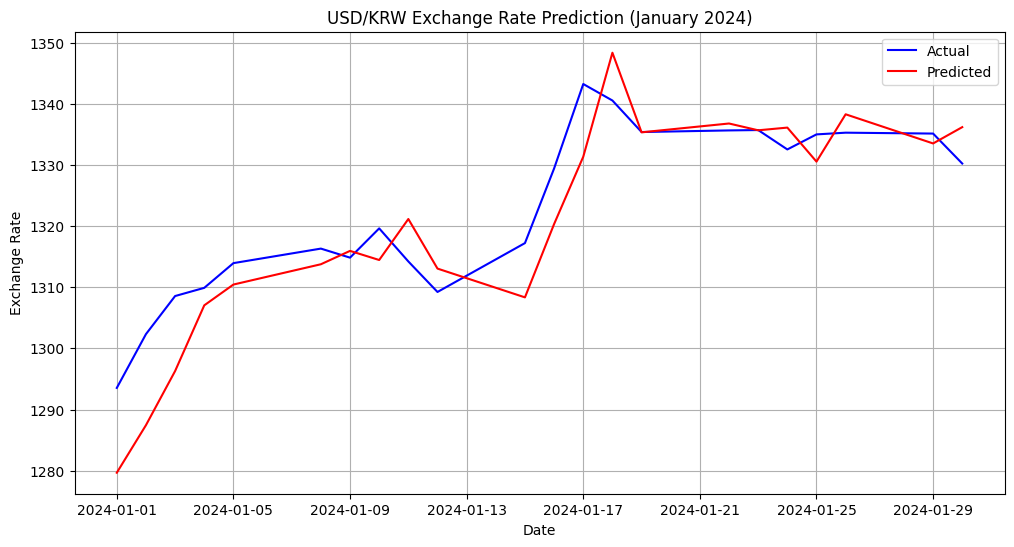


실제값과 예측값 비교:
                                Actual    Predicted
Date                                               
2024-01-01 00:00:00+00:00  1293.535034  1279.672294
2024-01-02 00:00:00+00:00  1302.330017  1287.445193
2024-01-03 00:00:00+00:00  1308.554993  1296.293645
2024-01-04 00:00:00+00:00  1309.894958  1307.034644
2024-01-05 00:00:00+00:00  1313.934998  1310.433943
2024-01-08 00:00:00+00:00  1316.309998  1313.751201
2024-01-09 00:00:00+00:00  1314.829956  1315.936297
2024-01-10 00:00:00+00:00  1319.614990  1314.446043
2024-01-11 00:00:00+00:00  1314.209961  1321.148390
2024-01-12 00:00:00+00:00  1309.220032  1313.043556
2024-01-15 00:00:00+00:00  1317.210022  1308.338417
2024-01-16 00:00:00+00:00  1329.410034  1320.325449
2024-01-17 00:00:00+00:00  1343.215027  1331.329017
2024-01-18 00:00:00+00:00  1340.520020  1348.331144
2024-01-19 00:00:00+00:00  1335.364990  1335.317994
2024-01-22 00:00:00+00:00  1335.630005  1336.761030
2024-01-23 00:00:00+00:00  1335.690002  1335.64952

In [35]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt

# 데이터 가져오기
usd_krw = yf.Ticker("KRW=X")
data = usd_krw.history(start="2019-01-01", end="2024-01-31")

# 수준 변수 계산
data['Level'] = (data['High'] + data['Low']) / 2

# 빈도 정보 추가 및 결측치 처리
data = data.asfreq('B')
data['Level'] = data['Level'].interpolate()

# 학습 및 테스트 데이터 분리
train_data = data.loc['2019-01-01':'2023-12-31', 'Level']
test_data = data.loc['2024-01-01':'2024-01-31', 'Level']

# 20일 단위 rolling forecast 함수
def rolling_forecast(train, test, window_size=20):
    history = train.copy()
    predictions = []
    for i in range(len(test)):
        model = ARIMA(history, order=(0,1,2))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)
        predictions.append(forecast.iloc[0])
        history = pd.concat([history, test.iloc[i:i+1]])
        if len(history) > window_size:
            history = history[-window_size:]
    return pd.Series(predictions, index=test.index)

# Rolling forecast 실행
forecast = rolling_forecast(train_data, test_data)

# RMSE와 MAE 계산
def calculate_metrics(actual, predicted):
    rmse = sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

rmse, mae = calculate_metrics(test_data, forecast)

# 정확도 계산
accuracy_rmse = 100 * (1 - rmse / test_data.mean())
accuracy_mae = 100 * (1 - mae / test_data.mean())

print(f"2024년 1월 예측 결과:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE 기반 정확도: {accuracy_rmse:.2f}%")
print(f"MAE 기반 정확도: {accuracy_mae:.2f}%")

# 결과 시각화
plt.figure(figsize=(12,6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')
plt.plot(forecast.index, forecast, label='Predicted', color='red')
plt.title('USD/KRW Exchange Rate Prediction (January 2024)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# 실제값과 예측값 비교
comparison = pd.DataFrame({'Actual': test_data, 'Predicted': forecast})
print("\n실제값과 예측값 비교:")
print(comparison)

# 평균 절대 백분율 오차(MAPE) 계산
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
print(f"\nMAPE: {mape:.2f}%")